# <center> Airlane Passenger Load Prediction - RAMP <center>
### <center> Tommy TRAN, Thomas de MAREUIL - Submission:[last submission name]<center>


## Table of contents
[1. Context and objective](#section1)

[2. Data Exploration (EDA) and Feature Engineering](#section2)

* [A. Structure of the initial datasets](##section2A)
* [B. Adding more external data](##section2B)
* [C. Data pre-processing: cleaning, merging, encoding](##section2C)


[3. Prediction](#section3)
* [A. Model selection](##section3A)
* [B. Hyperparameters tuning](##section3B)

[4. Conclusion](#section4)

<a id="section1"></a>
## 1. Context and objective

This report is our final project for the class [MAP536 - Python for Data Science](https://moodle.polytechnique.fr/course/view.php?id=6124).

The objective is to **forecast airplane passengers load** in the United States.

We were initially provided with:
* training data : information about US domestic flights between 2011 and 2013
* external data : meteorological information about US airports

Based on these first pieces of information, we identified several steps to work on and improve our predictions:

1. **Feature engineering**:  
    $\to$ look for additional external data  
    $\to$ clean it and merge it with preexisting data  
    $\to$ adjust data encoding  
    $\to$ check features relevance  
<br>
2. **Model selection and tuning:**  
    $\to$ try several models and select the best-performing    
    $\to$ try model averaging and stacking  
    $\to$ tune model hyperparameters with gridsearch  
<br>

In this report, we will go through these steps and present you the ideas we got, the techniques we tried, the models we explored and the results we obtained.

<a id="section2"></a>
## 2. Data Exploration and Feature Engineering

<a id="##section2A"></a>
### A. Structure of the initial datasets

The initial **training dataset** contained information about 8901 US domestic flights: date (from 09/01/2011 to 03/05/2013), departure and arrival airports (20 different airports for both), how early tickets were booked (in weeks) and the number of passengers (our predicted variable).

In [4]:
X_train.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159


In [5]:
X_train.shape

(8902, 5)

In [6]:
X_train.dtypes

DateOfDeparture      object
Departure            object
Arrival              object
WeeksToDeparture    float64
std_wtd             float64
dtype: object

In [7]:
print(min(X_train['DateOfDeparture']))
print(max(X_train['DateOfDeparture']))

2011-09-01
2013-03-05


In [8]:
X_train['Arrival'].unique()

array(['DFW', 'DEN', 'LAX', 'ORD', 'SFO', 'MCO', 'LAS', 'CLT', 'MSP',
       'EWR', 'PHX', 'DTW', 'MIA', 'BOS', 'PHL', 'JFK', 'ATL', 'LGA',
       'SEA', 'IAH'], dtype=object)

$\rightarrow$ These commands gave us an overview of the data.

In [9]:
pd.DataFrame(data=X_train.isna().sum(), columns=["Number of NAs"]).transpose()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
Number of NAs,0,0,0,0,0


$\rightarrow$ There are no missing values.

In [10]:
X_train.skew()

WeeksToDeparture    0.270212
std_wtd             0.066525
dtype: float64

$\rightarrow$ Skewness is low.

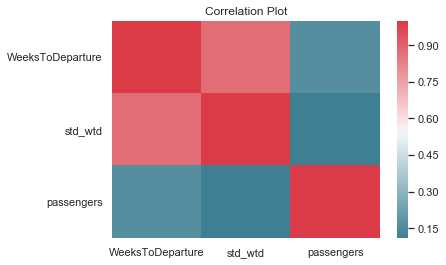

In [11]:
X_all=X_train.copy()
X_all["passengers"] = y_array

cor = X_all.corr(method='pearson')
sns.heatmap(cor, cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title("Correlation Plot"); plt.show()

$\rightarrow$ `std_wtd` (standard deviation of weeks to departure) is strongly correlated to `WeeksToDeparture` and little correlated to `passengers`, therefore we will not to use it in the regression.

The initial **external dataset** contained information about xx meteorological features for the 20 airports, during the corresponding time period. Each line represents the property of an airport at a given date.

In [58]:
external_data_init = pd.read_csv('https://raw.githubusercontent.com/ramp-kits/air_passengers/master/submissions/starting_kit/external_data.csv')
external_data_init.shape

(11040, 24)

In [14]:
external_data_init.head()

,Date,AirPort,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.00,3,NaN,129
1,2011-09-02,ATL,36,29,22,17,15,14,61,46,30,1019,1016,1014,16,16,16,24,7,34.0,0.00,2,NaN,185
2,2011-09-03,ATL,35,29,23,17,16,14,64,47,30,1015,1013,1011,16,16,16,19,7,26.0,0.00,4,NaN,147
3,2011-09-04,ATL,27,24,22,22,19,16,93,72,51,1014,1012,1011,16,14,4,21,9,26.0,6.10,6,Rain,139
4,2011-09-05,ATL,26,24,22,23,22,20,94,91,87,1010,1005,999,16,13,3,32,16,45.0,16.00,8,Rain-Thunderstorm,149


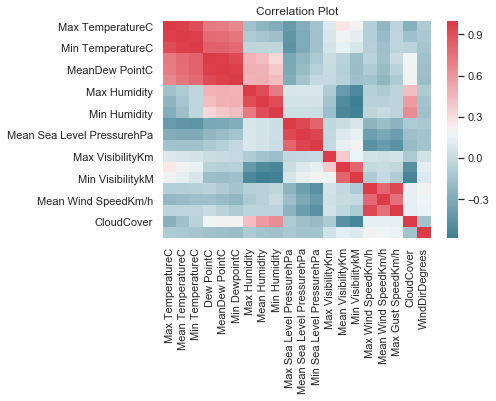

In [15]:
cor_ext = external_data_init.corr(method = 'pearson')
sns.heatmap(cor_ext, cmap = sns.diverging_palette(220, 10, as_cmap=True))
plt.title("Correlation Plot"); plt.show()

$\rightarrow$ Based on correlation, we kept only the Mean values for each feature that also had Min and Max values (i.e. `Temperature`, `Humidity`, etc.).

<a id="##section2B"></a>
### B. Adding more external data

We tried to identify the determinants of airplane passenger load, and after online research we came out with:

_General / time-related data:_
* **Holidays**: we added a binary indicator to identify holidays (ex: Matin Luther King Day, July 4th, Thanksgiving, etc.), with more plane traffic.  
* **Plane load factor**: percentage of empty seats in US domestic flights, obtained from the US Bureau of Transportation Services (BTS) database. We only found the average value per month, over the whole US market, which isn't very precise but gives and idea of plane load tendencies over the observed time period.  
* **Jet Fuel Prices**: found in the IATA (International Air Transport Association) database, jet fuel prices tend to impact the price of tickets and therefore passenger load.

_Data per airport:_
* **Airports ranking** and **frequentation** in terms of commercial passengers per year (IATA).  
* **City population and density** (IATA).  
* **Latitude and longitude (distances)**: the IATA database gave us latitude and longitude coordinates of the airports. We then explored the pyproj and geopy packages to compute distances, but we finally chose to use direct computation with the Haversine distance formula, which we embedded in the feature extractor.


_Data per flight route:_
* **Air time** (BTS): time spent in flight to link 2 airports.  
* **Average ticket prices** (US BTS): average ticket prices between 2 given US airports, which has a direct impact on passenger load. We did not find day by day values, but we obtained an averafe price per quarter over the observed period, for each of the relevant flight routes.  
* **Average daily number of passengers** for a given flight route (BTS): similarly, we found a quarter-by-quarter value of the daily number of passengers on the relevant flight routes, during the observed period.

<a id="##section2C"></a>
### C. Data pre-processing: cleaning, merging, encoding

__*Producing a clean external dataset*__

A tricky part was first to clean the data we found online, and then to merge it into a single `external_data` file, including new and pre-existing external data (as we needed to have a single file to upload on RAMP).  

For this we used mainly `pandas`, `numpy` and `datetime`. We had, for example, to drop and select values, to perform computations on columns, to match city names with airport codes, to change data types, to manipulate dates and times, to reindex rows, etc. As we found extensive data online, we were not confronted with the problem of missing values.  

We finally obtained 4 external datasets that we had to merge into a single file: the original weather data, our new general data (holidays, fuel prices, etc.), our new data per airport (airport ranking, latitude, longitude, city population, etc.) and our new data per flight route (flight time, average daily number of passengers, etc.). 

Weather data was sorted out by airport and date, so our new `airport_data` (sorted out by airport) and `general dat` (sorted out by date) were easy to merge using the `merge` function in `pandas`:

In [ ]:
weather_data = external_data_init.copy()
external_data = weather_data.merge(airport_data, how = left, left_on = 'AirPort', right_on = 'Airport_Code')
external_data = external_data.merge(general_data, how = left, left_on = 'Date', right_on = 'date')

For our new data per flight route (`route_data`), it was possible to merge it directly with the training data (sorted out by flight routes), but not possible with the other external data (sorted out by _single_ airports). So we just concatenated it to build a unique `external_data` file:

In [ ]:
external_data_final = pd.concat([external_data, route_data], axis=1)

In [17]:
external_data_final.head()

,Date,AirPort,Mean TemperatureC,MeanDew PointC,Mean Humidity,Mean Sea Level PressurehPa,Mean VisibilityKm,Mean Wind SpeedKm/h,CloudCover,Rank_2018,State,2018_freq,city,lat,lng,population,density,Fuel_price,Holiday,Month,Year,Quarter,LOAD_FACTOR,Year_route,Quarter_route,daily_passengers,average_fare,ROUTE,AIR_TIME_MEAN
0,2011-09-01,ATL,29,18,56,1019,16,6,3,1,GA,51866464,Atlanta,33.7627,-84.4225,5228750.0,1384.0,3.088,0,9,2011,3,81.82,2011.0,3.0,2335.0,208.31,ATLBOS,6002.21
1,2011-09-01,ORD,28,22,70,1013,15,9,1,3,IL,39874879,Chicago,41.8373,-87.6862,8675982.0,4612.0,3.088,0,9,2011,3,81.82,2011.0,4.0,2117.0,227.89,ATLBOS,6002.21
2,2011-09-01,LAX,18,14,76,1011,11,13,5,2,CA,42626783,Los Angeles,34.1139,-118.4068,12815475.0,3295.0,3.088,0,9,2011,3,81.82,2012.0,1.0,1704.0,235.04,ATLBOS,6002.21
3,2011-09-01,DFW,33,14,35,1013,16,14,1,4,TX,32800721,Dallas,32.7936,-96.7662,5733259.0,1524.0,3.088,0,9,2011,3,81.82,2012.0,2.0,2335.0,226.73,ATLBOS,6002.21
4,2011-09-01,DEN,28,3,22,1007,16,15,5,5,CO,31363573,Denver,39.7621,-104.8759,2787266.0,1774.0,3.088,0,9,2011,3,81.82,2012.0,3.0,2437.0,196.87,ATLBOS,6002.21


##### __*Merging with the training dataset*__

We built the feature extractor in order to select features from our new final `external_data` and merge them with the training data.  

The training data is sorted out by flight route, so part of our external data (the flight route data) was easy to merge. We just had to add a flight route column in the training data (`X_encoded` in code below), subdivise our external data to select the flight route data, and perform the merge using the new column.

We also split the dates in the training data using `datetime` so that the quarter and month appear, which helped us make sure our data merges on the correct dates:

In [ ]:
X_encoded['ROUTE'] = X_encoded[['Departure', 'Arrival']].apply(''.join, axis=1)

route_data = external_data[['daily_pass','AIR_TIME_MEAN','average_fare', 'ROUTE','Year','Quarter',]]

X_encoded = pd.merge(X_encoded, route_data, how = 'left', left_on = ['year','quarter','ROUTE'],
            right_on = ['Year_route','Quarter_route','ROUTE'], sort = False)

For the other features, related to single airports, we had to merge them _twice_ with training data, based on the 2 airports in the itinerary (once on the Departure airport, once on the Arrival airport). The feature extractor adds `_dep` and `_arr` suffixes in the column names in order to distinguish information related to departure and arrival airports: 

In [ ]:
Dep_data = airport_data.add_suffix('_Dep')
Arr_data = airport_data.add_suffix('_Arr')

X_encoded = pd.merge(X_encoded, Dep_data, how = 'left', left_on = ['DateOfDeparture', 'Departure'],
            right_on = ['Date_Dep', 'AirPort_Dep'], sort = False)   
X_encoded = pd.merge(X_encoded, Arr_data, how = 'left', left_on = ['DateOfDeparture', 'Arrival'],
            right_on = ['Date_Arr', 'AirPort_Arr'], sort = False)

Once the merger done, we used the haversine formula to compute distances between departure and arrival airports based on latitudes and longitudes:

In [ ]:
X_encoded['Distance'] = X_encoded.apply(lambda x: 
                        haversine(x['lng_Dep'], x['lat_Dep'], x['lng_Arr'], x['lat_Arr']), axis = 1)

__*Encoding categorical features*__

Before feeding the model, we still had to encode the categorical features, i.e. dates (split into year, month, week, day, weekday) and airports (Dep and Arr). We tried several encoding methods, especially **target encoding** and **one-hot encoding**. Target encoding did not yield efficient results.

$\rightarrow$ We therefore sticked to one-hot encoding:

In [ ]:
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Departure'], prefix = 'd'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Arrival'], prefix = 'a'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['year'], prefix='y'))
X_encoded = X_encoded.join(pd.get_dummies(X_encoded['month'], prefix='m')) #and so on.

__*Drop irrelevant features*__



We made several _back-and-forths_ with the model to test differents sets of features and assess them with feature importance analysis (see code below). We then included a line in the feature extractor to drop the least significant features, and produce our final `X_encoded` file, to be fed to the model:

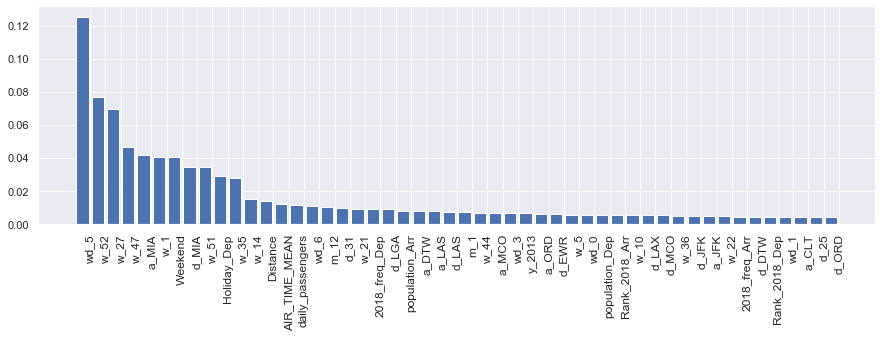

In [57]:
plt.figure(figsize=(15, 4))

ordering = np.argsort(XGB.feature_importances_)[::-1][:50]
importances = XGB.feature_importances_[ordering]

X_columns = X_train.columns
feature_names = X_columns[ordering]
x = np.arange(len(feature_names))

plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=12);

In [33]:
print(X_encoded.shape)
X_encoded.head()

(8902, 118)


,WeeksToDeparture,Mean TemperatureC,Rank_2018_Dep,population_Dep,density_Dep,Fuel_price_Dep,Holiday_Dep,LOAD_FACTOR_Dep,2018_freq_Dep,Rank_2018_Arr,population_Arr,density_Arr,2018_freq_Arr,Weekend,n_days,daily_passengers,average_fare,AIR_TIME_MEAN,d_ATL,d_BOS,d_CLT,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_ORD,d_PHL,d_PHX,d_SFO,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHX,a_SFO,y_2011,y_2013,m_1,m_3,m_4,m_5,m_6,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_7,d_8,d_9,d_10,d_12,d_18,d_23,d_25,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_14,w_20,w_21,w_22,w_26,w_27,w_35,w_36,w_37,w_38,w_41,w_44,w_46,w_47,w_49,w_50,w_51,w_52,q_1,q_2,q_3
0,12.875000,29,3,8675982.0,4612.0,2.719,0,86.62,39874879,4,5733259.0,1524.0,32800721,0.0,15510,3220.0,228.67,7560.62,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,14.285714,25,9,2073045.0,1747.0,3.247,0,80.64,23655285,5,2787266.0,1774.0,31363573,0.0,15593,2286.0,123.86,4407.42,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,10.863636,19,5,2787266.0,1774.0,3.158,0,84.23,31363573,2,12815475.0,3295.0,42626783,0.0,15618,4379.0,172.05,5667.64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,11.480000,19,1,5228750.0,1384.0,2.881,0,83.63,51866464,3,8675982.0,4612.0,39874879,1.0,15256,2746.0,193.12,3693.83,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,11.450000,12,5,2787266.0,1774.0,3.237,0,78.90,31363573,7,3603761.0,7286.0,27794154,0.0,15391,2681.0,182.97,5300.04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


<a id="section3"></a>
## 3. Prediction

<a id="##section3A"></a>
### A. Model Selection

We tried and evaluated several regression models locally, in order to obtain the lowest error rate on our testing set. Here are the results of our different tries, ranked from lowest to highest test rmse:

* **Exterme Gradient Boosting (`XGBoost`)**: the best-performing model, which we finally selected.  

```
----------------------------
train rmse = 0.137 ± 0.0025
test rmse = 0.267 ± 0.0072
```

(See next section for the final version of this model we used, with tuned hyperparameters)


* **Gradient Boosting**

```
----------------------------
train rmse = 0.405 ± 0.0117
test rmse = 0.302 ± 0.005
```

* **Random Forest**

```
----------------------------
train rmse = 0.529 ± 0.033
test rmse = 0.881 ± 0.023
```

* **Lasso Regression**

```
----------------------------
train rmse = 0.591 ± 0.0322
test rmse = 0.629 ± 0.023
```

* **Elastic Net Regression**

```
----------------------------
train rmse = 0.590 ± 0.032
test rmse = 0.629 ± 0.032
```

* **AdaBoost**

```
----------------------------
train rmse = 0.700 ± 0.0133
test rmse = 0.726 ± 0.032
```

* **Linear Regression**:

```
----------------------------
train rmse = 0.898 ± 0.013
test rmse = 0.841 ± 0.023
```

**_Model averaging / stacking_**  

We tried **averaging** the 3 best-performing models (XGBoost, GradientBoosting and RandomForest), which did not yield better results - probably due to the fact that these models are already ensembling methods.

**_Overfitting_**  

In the XGBoost case the model seems to overfit a little bit, but not significantly.

<a id="##section3B"></a>
### B. Hyperparameters tuning

We performed Grid Search using the `GridSearchCV` command (the `RandomizedSearchCV`is too costly), which is still quite demanding computationaly speaking but allowed us to come up with an efficient set of parameters for our XGBoost, gaining **-0,17** in test score compared to default parameters. Below, our GridSearch line and the final parameters we included in the model:

In [47]:
xgb_grid = GridSearchCV(xgb_model, parameters, cv = 2, n_jobs = 5, verbose=True)
xgb_grid.fit(X_train, y_train)

In [ ]:
XGB = xgb.XGBRegressor(colsample_bytree = 0.7, learning_rate = 0.03, 
                       max_depth = 10, min_child_weight = 4, n_estimators = 10000, nthread = 4, 
                       objective = 'reg:linear', silent = 1, subsample = 0.7)
XGB.fit(X_train, y_train)

<a id="section4"></a>
## 4. Conclusion

**_Answer to the problem_**

Using the model we built, an airline company would be able to predict passenger load on a given route and day. This could help them **allocate planes** (e.g. schedule more flights on highly-frequented routes), or tune their **pricing policy** (increase ticket prices on highly-frequented routes). Indirectly, it could also help them adjust their **resource management**, by allocating more resources (investments, additional staff, etc.) to the routes with the highest passenger load.

In addition, the predictions could be **further analysed** (for example grouped by week or month, comparde with other airline companies, etc.) in oder to produce additional insights about **what determines passenger traffic the most**, what are the **preferred dates**, the **preferred routes**... These additional analyses would very provide valuable information to the airline company in order to **help them improve business performance**.

**_What we learnt in this project_**

We confronted ourselves to the different steps of a data science project, from obtaining and pre-processing the data to choosing and tuning the model. We tried many different data manipulation techniques and explored several models along the way, with a constant back and forth between model tuning and features engineeering. We also learnt to use github in a team project.  

$\rightarrow$ This experience allowed us to apply what we learnt in class, and most of all it helped us learn a lot by exploring the internet (stack overflow, etc.) to find solutions to our problems, in a "learning by doing" approach!

**_Citical analysis of our model_**

Bonus (advanced)  
* model interpretability  
* evaluate uncertainty in predictions